# Build Chatbot
All chatbots come under the NLP (Natural Language Processing) concepts. NLP is composed of two things:

- NLU (Natural Language Understanding): The ability of machines to understand human language like English.

- NLG (Natural Language Generation): The ability of a machine to generate text similar to human written sentences.

In [1]:
import numpy as np
import nltk
import json
import pickle
import random
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD


In [2]:
lemmatizer = WordNetLemmatizer()
# load json data file
intents_file = open('data/intents.json').read()
intents = json.loads(intents_file)

type(intents)

dict

In [3]:
# processing data
words = list()
classes = list()
documents = list()
ignore_letters = ['!', '?', '.', ',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        # word tokenize
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)
        # add to documents
        documents.append((tokens, intent['tag']))
        # add to the classes
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

print(documents[:10])

[(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hey'], 'greeting'), (['Hola'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['Bye'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['Goodbye'], 'goodbye')]


In [4]:
# remove duplicate words with word lemmatize
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(list(set(words)))
words[:10]

["'s",
 'a',
 'adverse',
 'all',
 'anyone',
 'are',
 'awesome',
 'be',
 'behavior',
 'blood']

In [5]:
# save the classes and words into disk
#pickle.dump(words, open('words.pkl', 'wb'))
#pickle.dump(classes, open('classes.pkl', 'wb'))

In [6]:
# create training data
training = list()
output_empty = [0] * len(classes)
output_empty

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [7]:
# training set, bag of word for every sentence
for doc in documents:
    bag = list()
    word_patterns = doc[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns if word not in ignore_letters]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)
    # output is a 0 for each tag and 1 for current tag (each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
    
#training[0]

In [8]:
# shuffle training
random.shuffle(training)
training = np.asarray(training)
train_X = list(training[:, 0])
train_y = list(training[:, 1])
print(len(train_X), len(train_y))

47 47


/home/chuongnet/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [9]:
training[0]

array([list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
       list([0, 0, 0, 0, 0, 0, 0, 1, 0])], dtype=object)

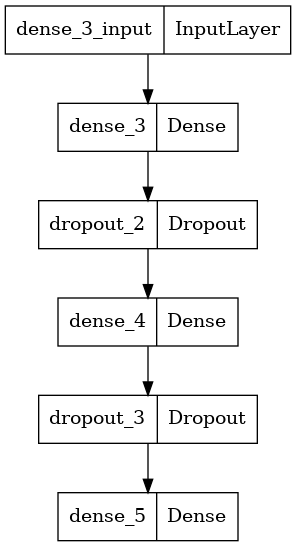

In [11]:
# create DL model
from tensorflow.keras.utils import plot_model


model = Sequential()
model.add(Dense(128, input_shape=(len(train_X[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
plot_model(model)

In [13]:
hist = model.fit(np.array(train_X), np.array(train_y), epochs=500, batch_size=5, verbose=0)

2022-04-02 17:51:22.156319: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
model.save('chatbot_model.h5', hist)